# Chapter 8
## Regression

## Outline

1. Introduce Regression (quickly)
2. Optimization techniques
3. Bias and Variance Tradeoff
4. Regularization

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso

Populating the interactive namespace from numpy and matplotlib


/Users/nobleWkennamer/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Linear Models

Given an independent variable $x_i$ and dependent variable $y_i$ we define the simpled model for regression:


$y_i = \theta_0 + \theta_1x_i + \epsilon_i $

where $\theta_0 $ and $\theta_1 $ are the coefficients and $\epsilon_i $ is additive noise.

Typically we assume that $\epsilon_i = N(0, \sigma_i)$ and that the dependent variables are independent.

With this assumpting we can write the likelihood

... I'll Do this on the board


## What the Data Looks Like for this chapter

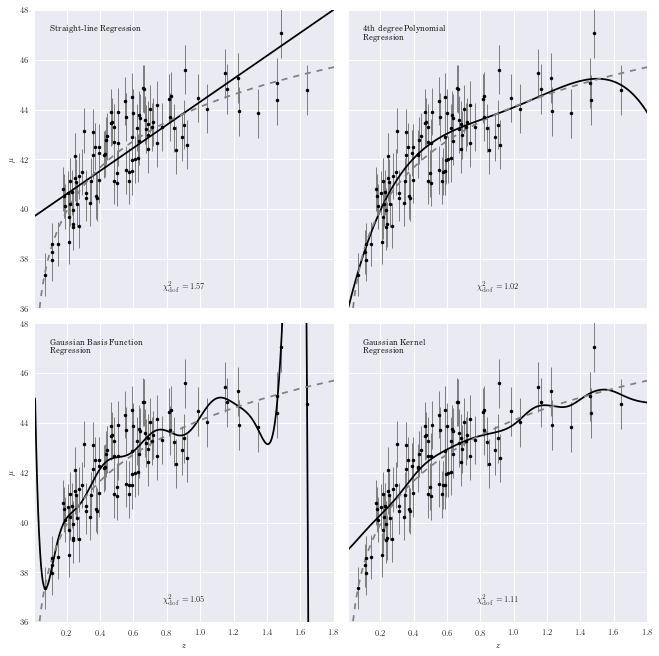

In [2]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression, PolynomialRegression,\
    BasisFunctionRegression, NadarayaWatson

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(map(cosmo.mu, z))

#------------------------------------------------------------
# Define our classifiers
basis_mu = np.linspace(0, 2, 15)[:, None]
basis_sigma = 3 * (basis_mu[1] - basis_mu[0])

subplots = [221, 222, 223, 224]
classifiers = [LinearRegression(),
               PolynomialRegression(4),
               BasisFunctionRegression('gaussian',
                                       mu=basis_mu, sigma=basis_sigma),
               NadarayaWatson('gaussian', h=0.1)]
text = ['Straight-line Regression',
        '4th degree Polynomial\n Regression',
        'Gaussian Basis Function\n Regression',
        'Gaussian Kernel\n Regression']

# number of constraints of the model.  Because
# Nadaraya-watson is just a weighted mean, it has only one constraint
n_constraints = [2, 5, len(basis_mu) + 1, 1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)

for i in range(4):
    ax = fig.add_subplot(subplots[i])

    # fit the data
    clf = classifiers[i]
    clf.fit(z_sample[:, None], mu_sample, dmu)

    mu_sample_fit = clf.predict(z_sample[:, None])
    mu_fit = clf.predict(z[:, None])

    chi2_dof = (np.sum(((mu_sample_fit - mu_sample) / dmu) ** 2)
                / (len(mu_sample) - n_constraints[i]))

    ax.plot(z, mu_fit, '-k')
    ax.plot(z, mu_true, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

    ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
            ha='center', va='bottom', transform=ax.transAxes)

    ax.set_xlim(0.01, 1.8)
    ax.set_ylim(36.01, 48)
    ax.text(0.05, 0.95, text[i], ha='left', va='top',
            transform=ax.transAxes)

    if i in (0, 2):
        ax.set_ylabel(r'$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    if i in (2, 3):
        ax.set_xlabel(r'$z$')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

plt.show()

## Housing Data

In [3]:
sales = pd.read_csv('kc_house_data.csv')

In [4]:
sales.columns

Index([u'id', u'date', u'price', u'bedrooms', u'bathrooms', u'sqft_living',
       u'sqft_lot', u'floors', u'waterfront', u'view', u'condition', u'grade',
       u'sqft_above', u'sqft_basement', u'yr_built', u'yr_renovated',
       u'zipcode', u'lat', u'long', u'sqft_living15', u'sqft_lot15'],
      dtype='object')

In [5]:
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Regularization

/Users/nobleWkennamer/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


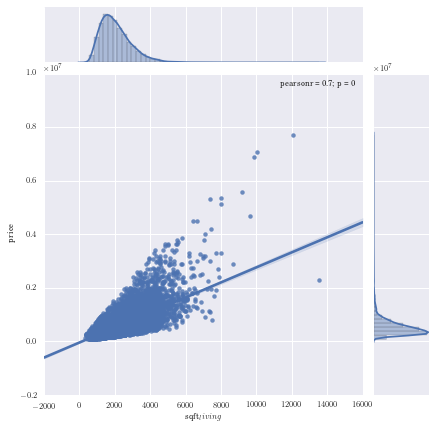

In [6]:
sns.jointplot(x='sqft_living', y='price', data=sales, kind='reg')

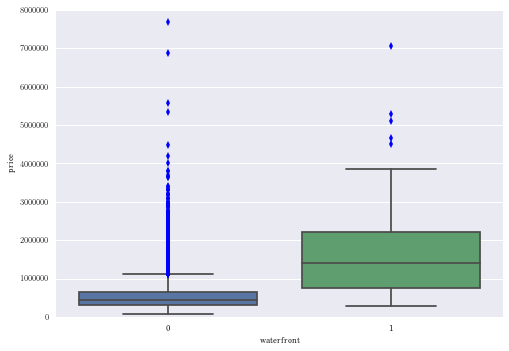

In [7]:
sns.boxplot(x='waterfront', y='price', data=sales)

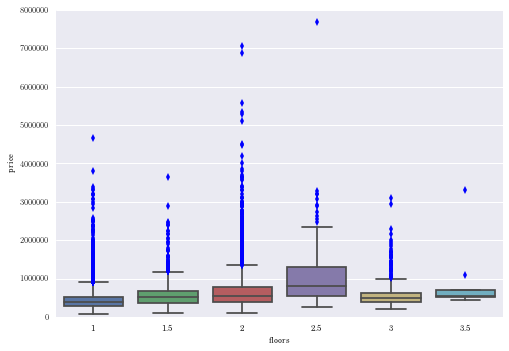

In [8]:
sns.boxplot(x='floors', y='price', data=sales, order=[1, 1.5, 2, 2.5, 3, 3.5])

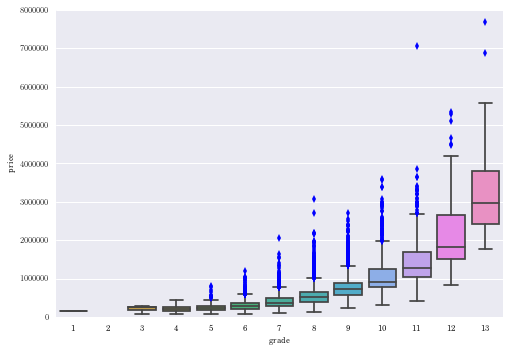

In [9]:
sns.boxplot(x='grade', y='price', data=sales, order=range(1, 14))

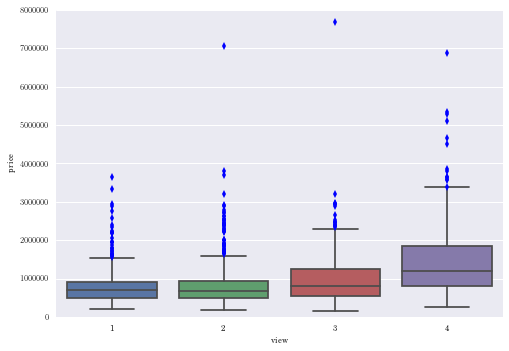

In [10]:
sns.boxplot(x='view', y='price', data=sales, order=range(1, 5))

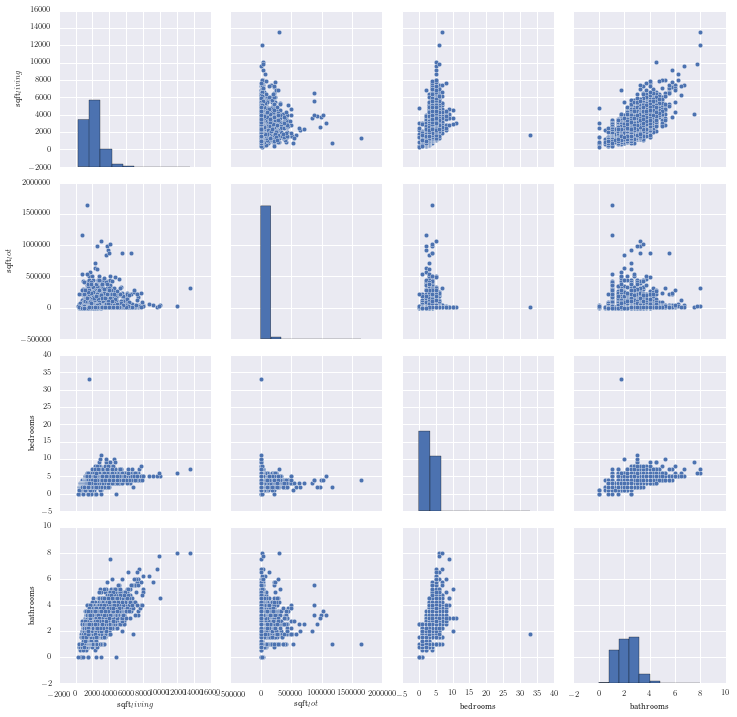

In [11]:
sns.pairplot(sales, vars=['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms'])

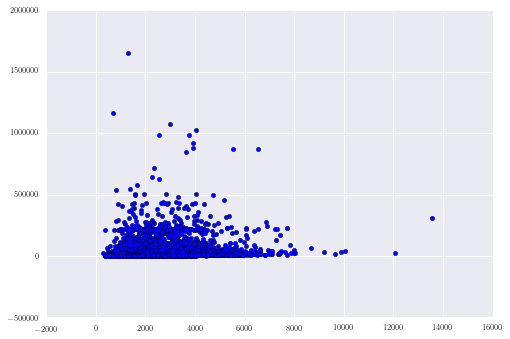

In [12]:
plt.scatter(sales['sqft_living'], sales['sqft_lot'])

## How to train a Regression Model

### Graident Descent

Introduce RSS and Gradient Descent on the board

In [13]:
def get_numpy_data(data_frame, features, output):
    data_frame['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_Frame given by the features list into the SFrame features_sframe (now including constant):
    features_frame = data_frame[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_frame.values
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_array = data_frame[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_array.values
    return(feature_matrix, output_array)

In [14]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

In [15]:
def feature_derivative(errors, feature):
    # Assume that errors and feature are both numpy arrays of the same length (number of data points)
    # compute twice the dot product of these vectors as 'derivative' and return the value
    derivative = 2 * np.dot(errors, feature)
    return(derivative)

In [16]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    converged = False 
    weights = np.array(initial_weights) # make sure it's a numpy array
    while not converged:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        gradient_sum_squares = 0 # initialize the gradient sum of squares
        # while we haven't reached the tolerance yet, update each feature's weight
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:, i] is the feature column associated with weights[i]
            # compute the derivative for weight[i]:
            derivative_i = feature_derivative(errors, feature_matrix[:, i])
            # add the squared value of the derivative to the gradient sum of squares (for assessing convergence)
            gradient_sum_squares += derivative_i**2
            # subtract the step size times the derivative from the current weight
            weights[i] -= step_size * derivative_i
        # compute the square-root of the gradient sum of squares to get the gradient matnigude:
        gradient_magnitude = np.sqrt(gradient_sum_squares)
        if gradient_magnitude < tolerance:
            converged = True
    return(weights)

In [17]:
simple_features = ['sqft_living']

full_data, output_data = get_numpy_data(sales, simple_features, 'price')
initial_weights = np.array([-47000., 1.])
step_size = 7e-12
tolerance = 2.5e7

In [18]:
full_weights = regression_gradient_descent(full_data, output_data, initial_weights, step_size, tolerance)

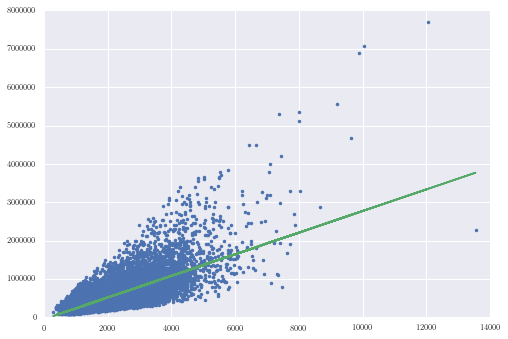

In [19]:
plt.plot(full_data[:, 1], output_data, '.',
         full_data[:, 1], predict_output(full_data, full_weights))

## Polynomial Regression and Overfitting

In [20]:
def polynomial_frame(feature, degree):
    # assume that degree >= 1
    # initialize the SFrame:
    poly_frame = pd.DataFrame()
    # and set poly_sframe['power_1'] equal to the passed feature
    poly_frame['power_1'] = feature
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_frame[name] = feature.apply(lambda x: x**power)
    return poly_frame

In [21]:
sales = sales.sort_values(by=['sqft_living', 'price'])

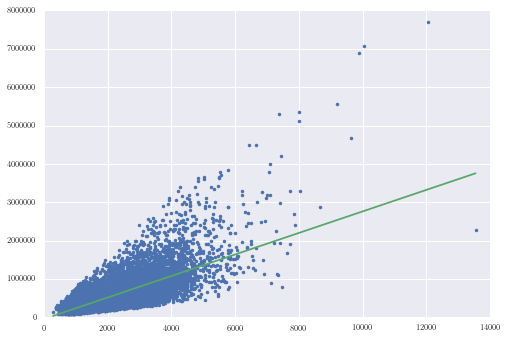

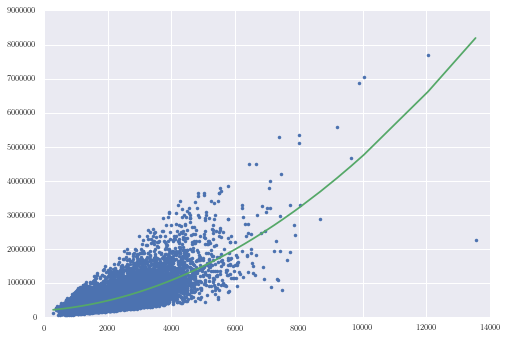

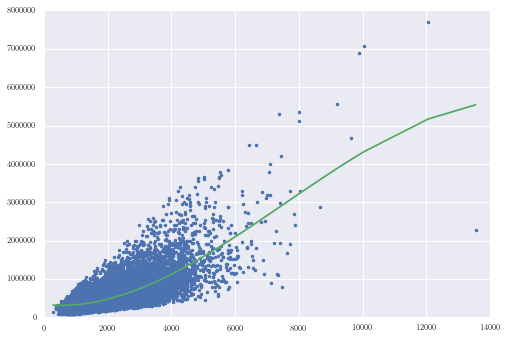

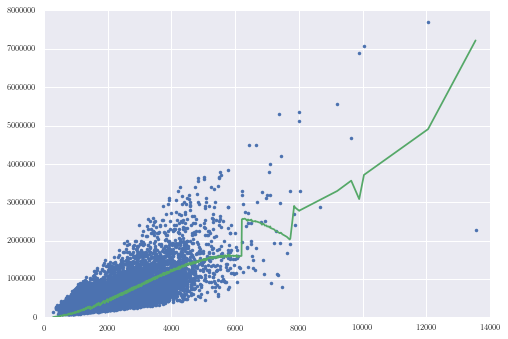

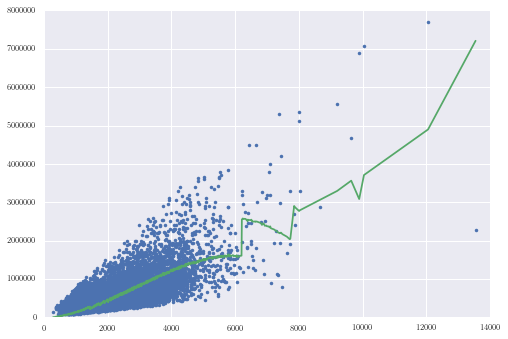

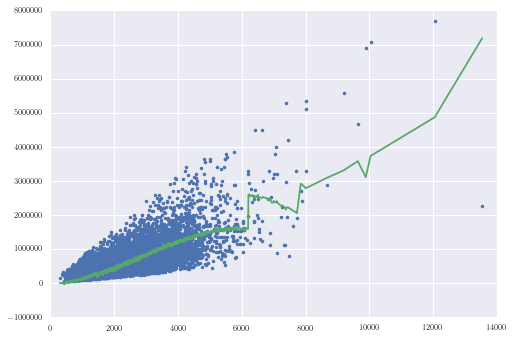

In [22]:
for deg in [1, 2, 3, 8, 12, 20]:
    poly_data = polynomial_frame(sales['sqft_living'], deg)
    lr = LinearRegression()
    lr.fit(poly_data, sales['price'])
    plt.plot(poly_data['power_1'], sales['price'], '.',
             poly_data['power_1'], lr.predict(poly_data))
    plt.figure()

## The Bias and Variance Tradeoff

... on the board

## The role of regularization

In [26]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant:
        derivative = 2*np.dot(errors, feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2*np.dot(errors, feature) + 2 * l2_penalty*weight
    return derivative

def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    
    for j in range(max_iterations):
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, True)
            else:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, False)

            # subtract the step size times the derivative from the current weight
            weights[i] -= step_size * derivative
    return weights

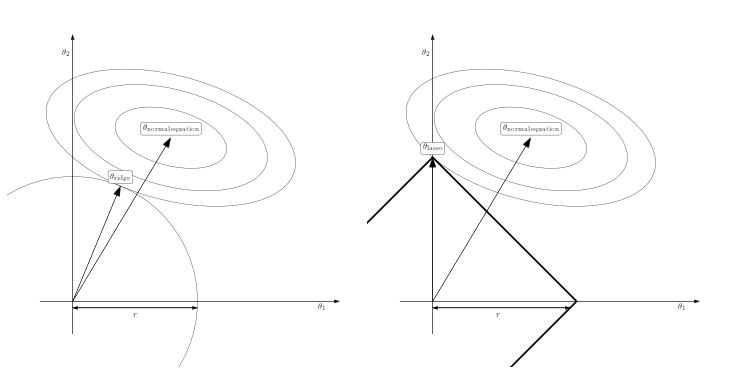

In [24]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse, Circle, RegularPolygon

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots

#------------------------------------------------------------
# Set up figure
fig = plt.figure(figsize=(10, 5), facecolor='w')

#------------------------------------------------------------
# plot ridge diagram
ax = fig.add_axes([0, 0, 0.5, 1], frameon=False, xticks=[], yticks=[])

# plot the axes
ax.arrow(-1, 0, 9, 0, head_width=0.1, fc='k')
ax.arrow(0, -1, 0, 9, head_width=0.1, fc='k')

# plot the ellipses and circles
for i in range(3):
    ax.add_patch(Ellipse((3, 5),
                         3.5 * np.sqrt(2 * i + 1), 1.7 * np.sqrt(2 * i + 1),
                         -15, fc='none'))

ax.add_patch(Circle((0, 0), 3.815, fc='none'))

# plot arrows
ax.arrow(0, 0, 1.46, 3.52, head_width=0.2, fc='k',
         length_includes_head=True)
ax.arrow(0, 0, 3, 5, head_width=0.2, fc='k',
         length_includes_head=True)
ax.arrow(0, -0.2, 3.81, 0, head_width=0.1, fc='k',
         length_includes_head=True)
ax.arrow(3.81, -0.2, -3.81, 0, head_width=0.1, fc='k',
         length_includes_head=True)

# annotate with text
ax.text(7.5, -0.1, r'$\theta_1$', va='top')
ax.text(-0.1, 7.5, r'$\theta_2$', ha='right')
ax.text(3, 5 + 0.2, r'$\rm \theta_{normal\ equation}$',
        ha='center', bbox=dict(boxstyle='round', ec='k', fc='w'))
ax.text(1.46, 3.52 + 0.2, r'$\rm \theta_{ridge}$', ha='center',
        bbox=dict(boxstyle='round', ec='k', fc='w'))
ax.text(1.9, -0.3, r'$r$', ha='center', va='top')

ax.set_xlim(-2, 9)
ax.set_ylim(-2, 9)

#------------------------------------------------------------
# plot lasso diagram
ax = fig.add_axes([0.5, 0, 0.5, 1], frameon=False, xticks=[], yticks=[])

# plot axes
ax.arrow(-1, 0, 9, 0, head_width=0.1, fc='k')
ax.arrow(0, -1, 0, 9, head_width=0.1, fc='k')

# plot ellipses and circles
for i in range(3):
    ax.add_patch(Ellipse((3, 5),
                         3.5 * np.sqrt(2 * i + 1), 1.7 * np.sqrt(2 * i + 1),
                         -15, fc='none'))

# this is producing some weird results on save
#ax.add_patch(RegularPolygon((0, 0), 4, 4.4, np.pi, fc='none'))
ax.plot([-4.4, 0, 4.4, 0, -4.4], [0, 4.4, 0, -4.4, 0], '-k')

# plot arrows
ax.arrow(0, 0, 0, 4.4, head_width=0.2, fc='k', length_includes_head=True)
ax.arrow(0, 0, 3, 5, head_width=0.2, fc='k', length_includes_head=True)
ax.arrow(0, -0.2, 4.2, 0, head_width=0.1, fc='k', length_includes_head=True)
ax.arrow(4.2, -0.2, -4.2, 0, head_width=0.1, fc='k', length_includes_head=True)

# annotate plot
ax.text(7.5, -0.1, r'$\theta_1$', va='top')
ax.text(-0.1, 7.5, r'$\theta_2$', ha='right')
ax.text(3, 5 + 0.2, r'$\rm \theta_{normal\ equation}$',
        ha='center', bbox=dict(boxstyle='round', ec='k', fc='w'))
ax.text(0, 4.4 + 0.2, r'$\rm \theta_{lasso}$', ha='center',
        bbox=dict(boxstyle='round', ec='k', fc='w'))
ax.text(2, -0.3, r'$r$', ha='center', va='top')

ax.set_xlim(-2, 9)
ax.set_ylim(-2, 9)

plt.show()

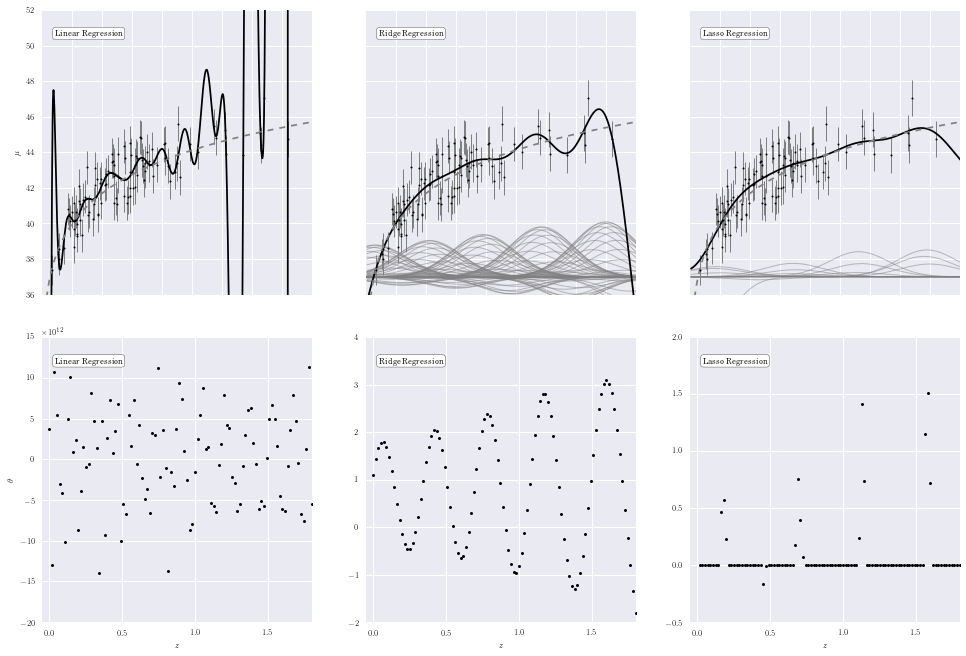

In [27]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# generate data
np.random.seed(0)

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)
cosmo = Cosmology()

z = np.linspace(0.01, 2, 1000)
mu = np.asarray(map(cosmo.mu, z))


#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 1.8, 100)
widths = 0.2
X = gaussian_basis(z_sample[:, np.newaxis], centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.15, wspace=0.2)

classifier = [LinearRegression, Ridge, Lasso]
kwargs = [dict(), dict(alpha=0.005), dict(alpha=0.001)]
labels = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

for i in range(3):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))

    # plot fit
    ax = fig.add_subplot(231 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)

    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(234 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

plt.show()